# Signal to noise calculations for the Australian Space Eye proposal

This notebook contains signal to noise calculations for the Australian Space Eye CubeSat space telescope proposal. The signal to noise/sensitivity are estimated for the main science aims of the mission, specifically absolute photometry of the Cosmic Infrared Background (CIB) and Zodiacal Light (ZL), and low surface brightness imaging of low redshift galaxies.

Two filter sets are considered:

1. 2 sets of 3 variant i and z band filters, designed to create 'virtual narrowband filters' in the Calcium triplet region in order to separate the CIB and ZL components.
1. 2 broadband i and z filters and 2 narrowband Calcium triplet 'on' and 'off' filters.

In each case each filter receives an equal share of the observing time.

## Standard imports

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import astropy.units as u
from astropy.table import Table
from scipy.optimize import least_squares

In [4]:
# Minimal, uncluttered notebook display of astropy Tables
def show_no_dtype(astropy_table):
    return HTML('\n'.join(astropy_table.pformat(html=True,
                                                show_dtype=False,
                                                tableclass="table-condensed table-bordered")))

## Import gunagala

`gungala` is the library that performs the SNR/sensitivity/ETC calculations. The main submodule is `imager` which includes the `Imager` class which represents an astronomical imaging instrument.

In [5]:
from gunagala import imager

/Users/ajh/anaconda/envs/POCS/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Create imagers

The `gunagala.imager.create_imagers()` creates a dictionary of `Imager` objects based on the `gunagala/data/performance.yaml` configuration file as well as performance data files in `gunagala/data/performance_data`. The instrument configuration/specifications should be set by editing these files.

Currently the file describes 2 variants of the Australian Space Eye concept and a 5 lens version of the Huntsman Telephoto Array.

In [6]:
imagers = imager.create_imagers()

ase_2016 = imagers['ase_2016']  # 6U with 1x 90 mm telescope & overlapping broadband filters
ase_2017 = imagers['ase_2017']  # 6U with 1x 90 mm telescope & broad and narrowband filters

waves_a = ase_2016.wavelengths

## Inspect imager properties

Many properties of the imagers can be accessed as properties of the `Imager` object.

### Filter profiles 

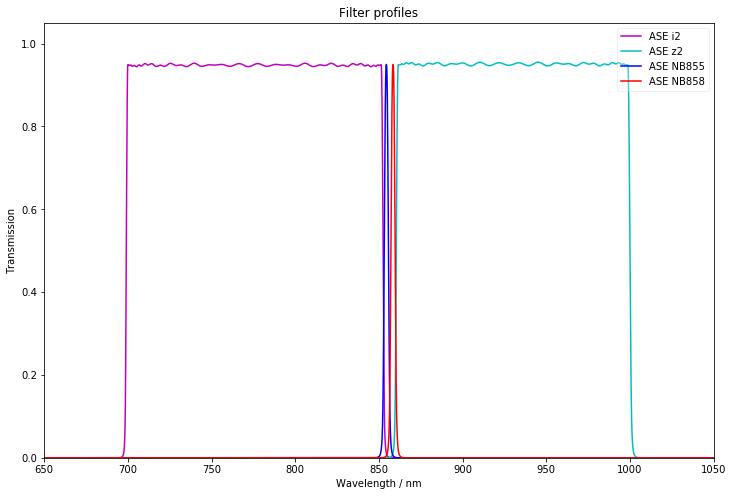

In [7]:
plt.plot(waves_a, ase_2017.filters['ase_i1'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2017.filters['ase_z3'].transmission(waves_a), 'c-', label='ASE z2')
plt.plot(waves_a, ase_2017.filters['ase_nb855'].transmission(waves_a), 'b-', label='ASE NB855')
plt.plot(waves_a, ase_2017.filters['ase_nb858'].transmission(waves_a), 'r-', label='ASE NB858')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(650, 1050)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

In [8]:
ase_2017.filters['ase_nb855'].FWHM

<Quantity 2.658233245264455 nm>

In [9]:
ase_2017.filters['ase_nb855'].lambda_c

<Quantity 854.3935690666981 nm>

In [10]:
ase_2017.filters['ase_nb858'].FWHM

<Quantity 2.666089320008723 nm>

In [11]:
ase_2017.filters['ase_nb858'].lambda_c

<Quantity 858.3907297645989 nm>

### Image sensor quantum efficiency

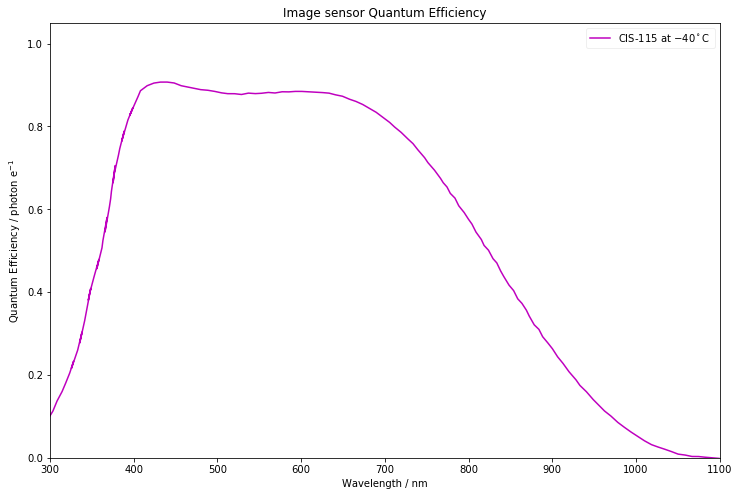

In [12]:
plt.plot(ase_2017.camera.wavelengths, ase_2017.camera.QE, 'm-', label='CIS-115 at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Quantum Efficiency / photon e$^{-1}$')
plt.title('Image sensor Quantum Efficiency')
plt.xlim(300, 1100)
plt.ylim(0,1.05)
plt.gcf().set_size_inches(12,8)

### End to end efficiency

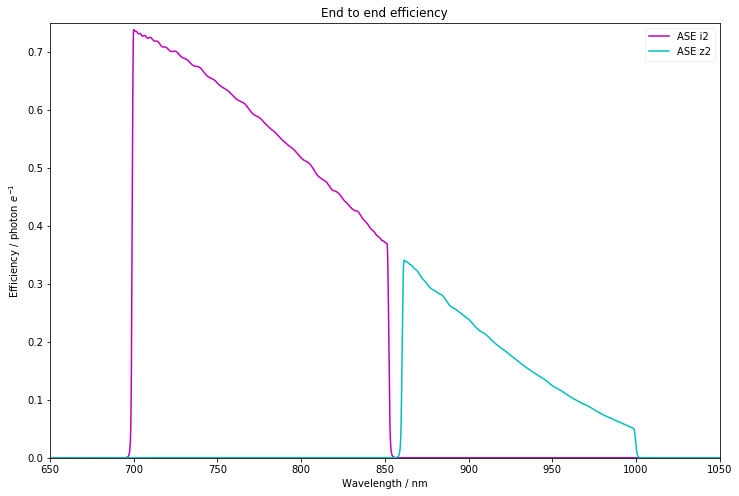

In [13]:
plt.plot(waves_a, ase_2017.efficiencies['ase_i1'], 'm-', label='ASE i2')
plt.plot(waves_a, ase_2017.efficiencies['ase_z3'], 'c-', label='ASE z2')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency / photon $e^{-1}$')
plt.title('End to end efficiency')
plt.xlim(650, 1050)
plt.ylim(0, 0.75)
plt.gcf().set_size_inches(12,8)

### Sky background model

For ASE the sky background is expected to dominated by the Zodiacal Light. For this we are use a scaled, reddened Solar spectrum following the prescription used by the HST ETC.

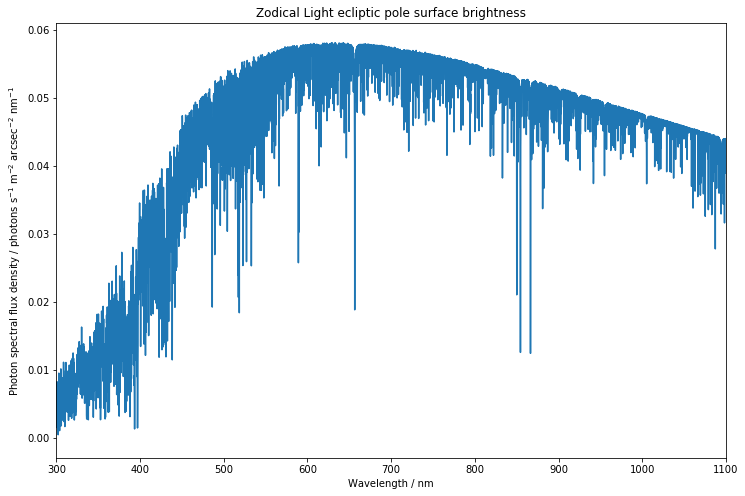

In [14]:
plt.plot(ase_2017.sky.waves.to(u.nm), 
         ase_2017.sky.photon_sfd.to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1))
plt.xlim(300, 1100)
plt.title('Zodical Light ecliptic pole surface brightness')
plt.xlabel('Wavelength / nm')
plt.ylabel('Photon spectral flux density / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ nm$^{-1}$')
plt.gcf().set_size_inches(12, 8)

### Filter transmission profile details


#### Virtual narrowband filter set

Close up of the blue edge of the 3 z band filter variants, shown together with the Zodiacal Light spectrum and its Calcium triplet absorption lines.

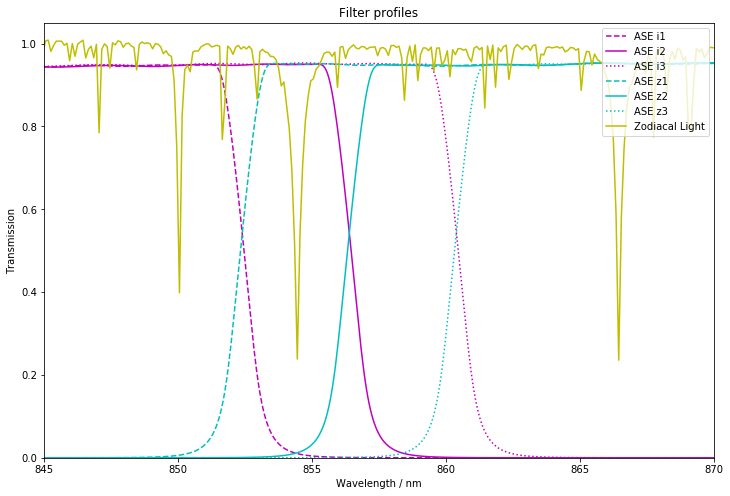

In [15]:
plt.plot(waves_a, ase_2016.filters['ase_i1'].transmission(waves_a), 'm--', label='ASE i1')
plt.plot(waves_a, ase_2016.filters['ase_i2'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2016.filters['ase_i3'].transmission(waves_a), 'm:', label='ASE i3')

plt.plot(waves_a, ase_2016.filters['ase_z1'].transmission(waves_a), 'c--', label='ASE z1')
plt.plot(waves_a, ase_2016.filters['ase_z2'].transmission(waves_a), 'c-', label='ASE z2')
plt.plot(waves_a, ase_2016.filters['ase_z3'].transmission(waves_a), 'c:', label='ASE z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 *ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

The 'virtual narrowband filters' that result from the pair-wise differences between the 3 z band filters coincide with the strongest Ca-triplet absorption line and adjacent continuum.  Meaurements of the sky background in these 3 filters therefore allow a measurement of the depth of the Ca-triplet absorption.



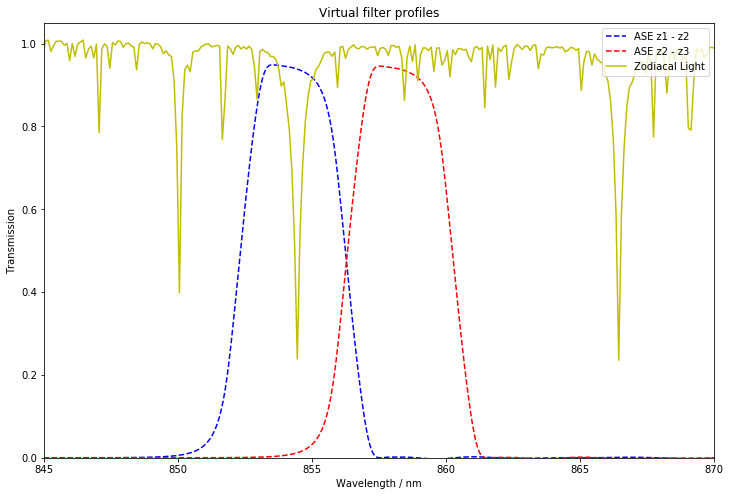

In [16]:
plt.plot(waves_a, 
         ase_2016.filters['ase_z1'].transmission(waves_a) - ase_2016.filters['ase_z2'].transmission(waves_a),
         'b--', label='ASE z1 - z2')
plt.plot(waves_a,
         ase_2016.filters['ase_z2'].transmission(waves_a) - ase_2016.filters['ase_z3'].transmission(waves_a),
         'r--', label='ASE z2 - z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 * ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 
         'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Virtual filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

#### Standard filter set

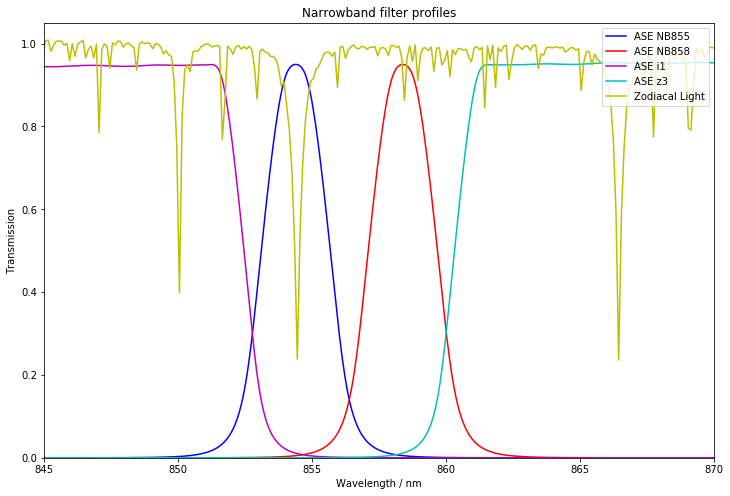

In [17]:
plt.plot(waves_a, ase_2017.filters['ase_nb855'].transmission(waves_a), 'b-', label='ASE NB855')
plt.plot(waves_a, ase_2017.filters['ase_nb858'].transmission(waves_a), 'r', label='ASE NB858')

plt.plot(waves_a, ase_2016.filters['ase_i1'].transmission(waves_a), 'm-', label='ASE i1')
plt.plot(waves_a, ase_2016.filters['ase_z3'].transmission(waves_a), 'c-', label='ASE z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 * ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 
         'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Narrowband filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

### Detected sky background levels

Pre-calculated for each filter. Also dark current for comparison.

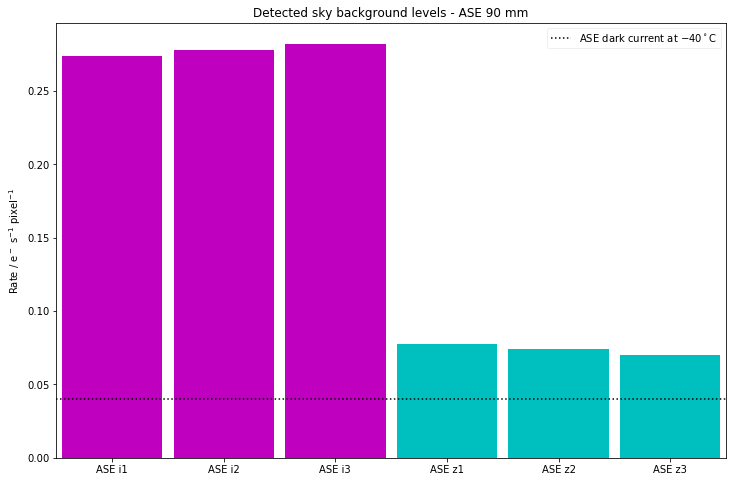

In [18]:
plt.bar((1, 2, 3, 4, 5, 6),
        (ase_2016.sky_rate['ase_i1'].value,
         ase_2016.sky_rate['ase_i2'].value,
         ase_2016.sky_rate['ase_i3'].value,
         ase_2016.sky_rate['ase_z1'].value,
         ase_2016.sky_rate['ase_z2'].value,
         ase_2016.sky_rate['ase_z3'].value),
        width=0.9, align='center', color=('m', 'm', 'm', 'c', 'c', 'c'))
plt.hlines(ase_2016.camera.dark_current.value, 0.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlim(0.5,6.5)
plt.xticks((1, 2, 3, 4, 5, 6), ('ASE i1', 'ASE i2', 'ASE i3', 'ASE z1', 'ASE z2', 'ASE z3'))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels - ASE 90 mm')

plt.gcf().set_size_inches(12, 8)

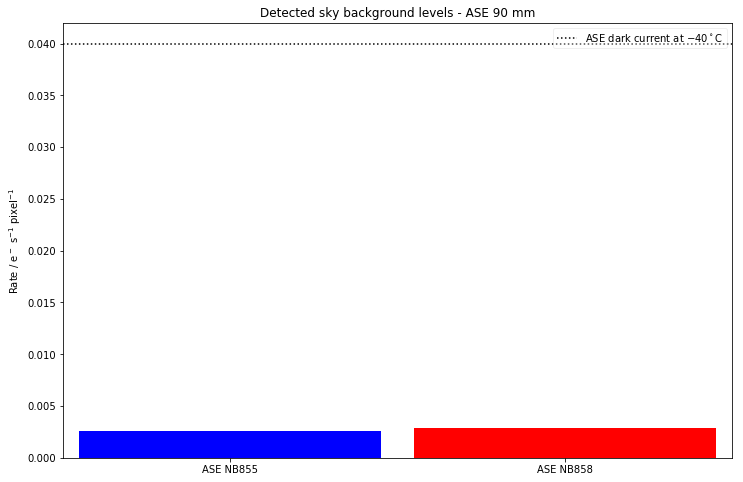

In [19]:
plt.bar((1, 2),
         (ase_2017.sky_rate['ase_nb855'].value,
          ase_2017.sky_rate['ase_nb858'].value),
          width=0.9, align='center', color=('b', 'r', 'b', 'r'))

plt.hlines(ase_2016.camera.dark_current.value, 0.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlim(0.5,2.5)
plt.xticks((1, 2), ('ASE NB855', 'ASE NB858'))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels - ASE 90 mm')

plt.gcf().set_size_inches(12, 8)

## Broadband imaging sensitivity

For broadband i and z band imaging we combine the data from all the i band and all the z band filters together.

We expect to observe for approximately 40 minutes of each 100 minute orbit.  Individual sub exposures that therefore be up to 40 minutes long, cosmic rays permitting.

Nominal mission duration is 2 years, allowing up to several months on each target field.

In [20]:
duty_cycle = 40 / 100

### Basic extended source sensitivity, 1 month

Limiting surface brightness in AB magnitudes per square arcsecond given a signal to noise ratio threshold of 1.0 per arcsecond squared and 1 month on target.

#### Virtual narrowband filter set

Here we can consider the 3 variant i and 3 variant z filters to be essentially the same and sum them together. The effective fraction of total exposure time for either or i or z band is then 1/2.

In [21]:
filter_fraction = 3 / 6

iasv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i2',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

zasv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z2',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

#### Standard broadband filters

Here we have i, z, and 2 narrowband filters. Assuming each are given equal exposure time then each broadband filter gets 1/4 of the total exposure time.

In [22]:
filter_fraction = 1 / 4

iasb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i1',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

zasb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z3',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

#### Results

In [23]:
t1 = Table(data = (('Virtual narrowband', 'Standard broadband'),
                   u.Quantity((iasv, iasb)).round(decimals=2),
                   u.Quantity((zasv, zasb)).round(decimals=2)),
           names=('Filter set', 'i band', 'z band'))
show_no_dtype(t1)

Filter set,i band,z band
,mag(AB),mag(AB)
Virtual narrowband,27.97,26.98
Standard broadband,27.58,26.56


### Extended source sensitivity, 1 months with binning

Our highest priority science targets will be very extended, allowing significant spatial binning after removal of compact source contaminants. For these a signal to noise threshold of, say, 1.0 per square _arcminute_ may be more appropriate than square arcsecond.  This is equivalent to an SNR of 1/60 per square arcsecond.

#### Virtual narrowband filter set

In [24]:
filter_fraction = 3 / 6

iamv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i2',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

zamv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z2',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

#### Standard broadband filters

In [25]:
filter_fraction = 1 / 4

iamb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i1',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

zamb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z3',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

#### Results

In [26]:
t2 = Table(data = (('Virtual narrowband', 'Standard broadband'),
                   u.Quantity((iamv, iamb)).round(decimals=2),
                   u.Quantity((zamv, zamb)).round(decimals=2)),
           names=('Filter set', 'i band', 'z band'))
show_no_dtype(t2)

Filter set,i band,z band
,mag(AB),mag(AB)
Virtual narrowband,32.42,31.43
Standard broadband,32.03,31.01


## Cosmic Infrared Background & Zodiacal Light measurements

The Cosmic Infrared Background (CIB) and Zodiacal Light (ZL) are both components of the sky background, with ZL being the dominant one. ASE aims to measure the absolute surface brightness of both using multiband photometry, taking advantage of the Calcium triplet absorption features in the ZL spectrum.  The Zodical Light is expected to have equal Ca-triplet depth to the Solar spectrum while the extragalactic background light will not exhibit any absorption lines. Consequently a measurement of the sky background Ca-triplet absorption depth allows the separation of Zodical Light and extragalactic components.

In practice the measurement of the CIB and ZL will be acheived by fitting models to the multiband photometry from ASE. In order to estimate the signal to noise in the fitted parameters we will use a highly simplified model and fitting procedure.

### Cosmic Infrared Background estimate

We base this on the lower limits for the integrated galactic light (IGL) from Driver et al 2017. There are expressed in terms of total flux for each band so we need to divide by the filter bandwidths to convert these to a band averaged spectral flux density, convert to photon based units and then interpolate the spectral energy distribution across the Space Eye wavelength range.

In [27]:
cib_waves = (749, 895) * u.nm # Pivot wavelengths of the filters used
cib_limit = (9.35, 9.98) * u.W * u.m**-2 * u.sr**-1 / 1e9 # Lower limits, bandpass totals

In [28]:
cib_limit_sfd = (cib_limit / (150 * u.nm)).to(u.W * u.m**-2 * u.arcsecond**-2 * u.nm**-1) # Divide by bandpass
cib_limit_sfd

<Quantity [  1.46510950e-21,  1.56382811e-21] W / (arcsec2 m2 nm)>

In [29]:
cib_unsurface_brightness = cib_limit_sfd * u.arcsecond**2 # Need to change units to use spectral_density equivalencies
cib_limit_photon = cib_unsurface_brightness.to(u.photon * u.s**-1 * u.m**-2 * u.nm**-1, 
                                    equivalencies=u.equivalencies.spectral_density(cib_waves))
cib_limit_photon = cib_limit_photon / u.arcsecond**2 # Change back to surface brightness units
cib_limit_photon

<Quantity [ 0.00552427, 0.00704588] ph / (arcsec2 m2 nm s)>

In [30]:
cib_gradient = (cib_limit_photon[1] - cib_limit_photon[0]) / (cib_waves[1] - cib_waves[0])
cib_gradient = cib_gradient.to(u.photon * u.s**-1 * u.nm**-2 * u.arcsecond**-2 * u.m**-2)
cib_gradient

<Quantity 1.0421971830375685e-05 ph / (arcsec2 m2 nm2 s)>

In [31]:
cib_850 = cib_limit_photon[0] + (cib_gradient * (850 * u.nm - cib_waves[0]))
cib_850

<Quantity 0.006576893125416034 ph / (arcsec2 m2 nm s)>

In [32]:
def cib_model(wavelengths, scale=cib_850, slope=cib_gradient):
    cib = slope * (wavelengths - 850 * u.nm) + scale
    return cib.to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1)

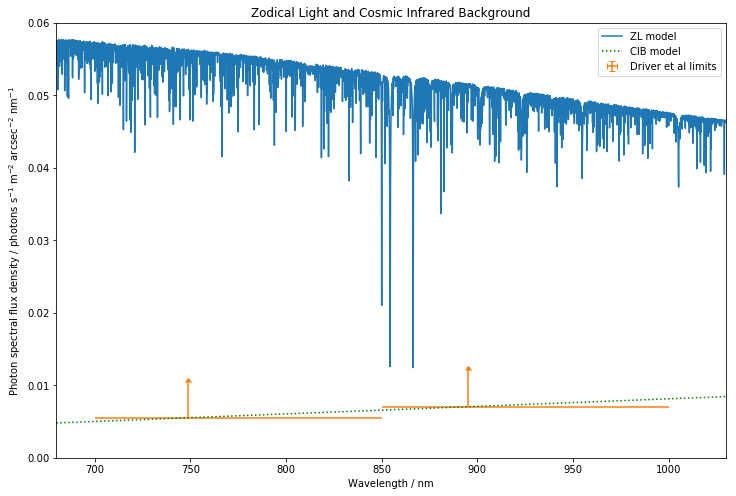

In [33]:
plt.plot(ase_2017.sky.waves.to(u.nm), 
         ase_2017.sky.photon_sfd.to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1), label='ZL model')
plt.errorbar(cib_waves.value, cib_limit_photon.value, xerr=((49,45), (101, 105)), 
             yerr=0.005, lolims=True, linestyle='none', label='Driver et al limits')
plt.plot(ase_2017.wavelengths, cib_model(ase_2017.wavelengths), 'g:', label='CIB model')
plt.legend()
plt.xlim(680, 1030)
plt.ylim(0,0.06)
plt.title('Zodical Light and Cosmic Infrared Background')
plt.xlabel('Wavelength / nm')
plt.ylabel('Photon spectral flux density / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ nm$^{-1}$')
plt.gcf().set_size_inches(12,8)

### Model photometric data

We then use the Zodical Light and Cosmic Infrared Background models to predict total signal and noise as measured in the Space Eye photometric bands. The model is parameterised by the ZL flux scaling, cosmic CIB flux scaling and CIB spectral slope, all expressed relative to the nominal values used above. 

We consider 1 month of elapsed time per target field with a duty cycle of 40%, 40 minute sub-exposures and exposure time equally divided between each of the filters to be the baseline for high ecliptic latitude CIB fields.

In [34]:
duty_cycle = 40 / 100

def model_data(zl_scaling, cib_scaling, cib_slope, 
               instrument=ase_2016,
               total_elapsed_time=30 * u.day,
               sub_exposure_time=40 * u.minute,
               binning_scale=1 * u.arcminute,
               add_noise=False):
    
    if instrument == ase_2016:
        # Virtual narrowband filter set (6 filters)
        filter_fraction = 1 / 6
    elif instrument == ase_2017:
        # Standard narrowband filter set (4 filters)
        filter_fraction = 1 / 4
    else:
        raise ValueError("Undefined imager, '{}'!".format(instrument))
        
    t_exp = total_elapsed_time * duty_cycle * filter_fraction
    
    data={}
    
    for filter_name in instrument.filter_names:
        cib_signal, noise = instrument.extended_source_signal_noise(surface_brightness=lambda w: cib_model(w,
                                                                                                           cib_scaling * cib_850,
                                                                                                           cib_slope * cib_gradient),
                                                                  filter_name=filter_name,
                                                                  total_exp_time=t_exp,
                                                                  sub_exp_time=sub_exposure_time,
                                                                  calc_type='per arcsecond squared')
        
        zl_signal, noise_again = instrument.extended_source_signal_noise(surface_brightness=None,
                                                                       filter_name=filter_name,
                                                                       total_exp_time=t_exp,
                                                                       sub_exp_time=sub_exposure_time,
                                                                       calc_type='per arcsecond squared')
        
        # Spatial binning
        cib_signal = (cib_signal * binning_scale**2).to(u.electron)
        zl_signal = (zl_signal * binning_scale**2).to(u.electron)
        binning_scale = binning_scale.to(u.arcsecond)
        noise = (noise * binning_scale.value * binning_scale.unit**2).to(u.electron)
        noise_again = (noise_again * binning_scale.value * binning_scale.unit**2).to(u.electron)
    
        # Adjust noise in accordance with ZL scaling
        scaled_noise = ((zl_scaling - 1) * noise_again**2 + noise**2)**0.5
    
        if add_noise:
            # Add random noise to expectation value
            data[filter_name] = cib_signal + zl_scaling * zl_signal + \
                np.random.normal(scale=scaled_noise.value) * scaled_noise.unit
        else:
            # Return expectation value and noise
            data[filter_name] = (cib_signal + zl_scaling * zl_signal, scaled_noise)
        
    return data

#### Virtual narrowband filter set

Expected values for 1 month's combined data, expressed in terms of the total signal and noise in electrons per square arcsecond for each filter, for the default values of the parameters.

In [35]:
model_data(1.0, 1.0, 1.0, instrument=ase_2016, binning_scale=1 * u.arcsecond)

{'ase_i1': (<Quantity 5804.535226375709 electron>,
  <Quantity 81.85032719961437 electron>),
 'ase_i2': (<Quantity 5886.842841187845 electron>,
  <Quantity 82.35158576187874 electron>),
 'ase_i3': (<Quantity 5986.752289056733 electron>,
  <Quantity 82.95597100489486 electron>),
 'ase_z1': (<Quantity 1708.289017234874 electron>,
  <Quantity 51.021856625794186 electron>),
 'ase_z2': (<Quantity 1622.4570863288027 electron>,
  <Quantity 50.17367758732688 electron>),
 'ase_z3': (<Quantity 1534.8237818897537 electron>,
  <Quantity 49.29264263759834 electron>)}

#### Standard narrowband filter set

Expected values for 1 month's combined data, expressed in terms of the total signal and noise in electrons per square arcsecond for each filter, for the default values of the parameters.

In [36]:
model_data(1.0, 1.0, 1.0, instrument=ase_2017, binning_scale=1 * u.arcsecond)

{'ase_i1': (<Quantity 8706.802839563561 electron>,
  <Quantity 100.24576845945118 electron>),
 'ase_nb855': (<Quantity 86.67002463726269 electron>,
  <Quantity 37.80319138775983 electron>),
 'ase_nb858': (<Quantity 93.19163207118628 electron>,
  <Quantity 37.88935056890686 electron>),
 'ase_z3': (<Quantity 2302.235672834631 electron>,
  <Quantity 60.37091126773694 electron>)}

### Sensitivity estimates

To estimate the signal to noise in the measurements of the zodiacal light and cosmic infrared background we use the model to generate sets of simulated data with noise then fit the model to the noisy data in order to recover the ZL flux scaling, CIB flux scaling and CIB spectral slope parameters. Using a brute force Monte Carlo method we can obtain a simple estimate of the uncertainty in the recovered parameters.

In [37]:
def residual(params, 
             data,
             instrument,
             binning_scale=1 * u.arcminute,
             total_elapsed_time=30 * u.day,
             sub_exposure_time=40 * u.minute):
    
    model = model_data(params[0], params[1], params[2],
                       instrument=instrument,
                       binning_scale=binning_scale,
                       total_elapsed_time=total_elapsed_time,
                       sub_exposure_time=sub_exposure_time,
                       add_noise=False)
    residuals = []
    
    for filter_name in instrument.filter_names:
        datum = data[filter_name]
        residuals.append((datum - model[filter_name][0]) / model[filter_name][1])
        
    return residuals


def simple_mc(instrument, binning_scale, n=50):
    parameters=[]

    for i in range(n):
        data = model_data(1.0, 1.0, 1.0, instrument=instrument, binning_scale=binning_scale, add_noise=True)
        fit = least_squares(residual, (1.0, 1.0, 1.0),
                            bounds=((0.9, 0.0, -5.0), (1.1, 2.0, 5.0)),
                            kwargs={'data':data,
                                    'instrument':instrument,
                                    'binning_scale':binning_scale})
        parameters.append(fit.x)

    return np.array(parameters)

For these simplified calculations we will assume binning of the signal over the full field of view. In reality we will fit a more sophisticated spatially dependent model with strong priors on spatial variations based on previous observations of the smoothness of the Zodiacal Light. The resulting signal to noise would be similar.

In [38]:
binning_scale = (ase_2017.field_of_view[0] * ase_2017.field_of_view[1])**0.5
binning_scale

<Quantity 1.4461538962772391 deg>

#### Virtual narrowband filter set

In [39]:
virtual_nb_results = simple_mc(ase_2016, binning_scale)

The mean values of the fitted parameters should reproduce the original model, i.e. (1.0, 1.0, 1.0)

In [40]:
virtual_nb_results.mean(axis=0)

array([ 1.00017406,  0.99864355,  1.00057958])

The standard deviation of the fitted parameters gives the fractional statistical uncertainty in the ZL flux scaling, CIB flux scaling and CIB spectral slope.

In [41]:
virtual_nb_results.std(axis=0, ddof=1)

array([ 0.00184695,  0.01443763,  0.00602741])

#### <font color='red'>CONCLUSIONS:<font>  Space Eye Deep Fields (virtual narrow bands)
The above calculations are for 1 month pointing at one field and spatially binning the data over the entire field of view. It assumes the EBL lower limits from Driver et al., (2016), which imply the EBL is 10-15% of the Zodiacal Light (ZL). The "virtual narrow-bands" are used, which are given in the section **Filter transmission profile details** above.

**For the deep field, the accuracy on the ZL measurement is estimated to be 0.2% and for the EBL measurement, 1%. As the deep field will be revisited at least 2-3 times (to account for seasonal variations in ZL), this is an upper limit on the EBL accuracy we expect to achieve for each field. Over 1 year, we will have 3-4 separate deep fields, which will further reduce systematics and increase the measurement signal.**

#### <font color='red'>CONCLUSIONS:<font>  Space Eye Shallow Fields (virtual narrow bands)
The *deep fields* will be far from the Solar System's plane, where ZL is minimal. In contrast, a typical *shallow fields* will target regions where the ZL will be much higher and indeed the EBL component will eventually become negligable. The shallow fields will thus be used to:
 - build up a complete ZL model throughout the Solar System
 - validate the virtual narrow band method
 - target fields simultaneously observed with JWST to recover EBL at JWST wavelengths
 
**Observing a shallow field for a single day, the accuracy on the ZL measurement (again binning entire field of view) is 1% near the pole of the Solar System plane. This is a worse case scenario, as a typical shallow fields will be much closer to the plane. Thus the constraints on the ZL will be much less than 1% for nearly all of the shallow fields.**

#### Standard narrowband filter set

In [42]:
standard_nb_results = simple_mc(ase_2017, binning_scale)

The mean values of the fitted parameters should reproduce the original model, i.e. (1.0, 1.0, 1.0)

In [43]:
standard_nb_results.mean(axis=0)

array([ 1.00002889,  0.99977594,  1.00014594])

The standard deviation of the fitted parameters gives the fractional statistical uncertainty in the ZL flux scaling, CIB flux scaling and CIB spectral slope.

In [44]:
standard_nb_results.std(axis=0, ddof=1)

array([ 0.00086661,  0.00677896,  0.00283062])

#### <font color='red'>CONCLUSIONS:<font>  Space Eye (standard narrow bands)
The sensitivity of a standard set of narrow-band filters designed to measure the strength of the ZL increases by a factor of ~2 compared to the virtual narrow-band case. The cost/benefit of these options will need to be explored further, though it implies either option are viable.